# Capstone Project: Police Call Outcome Prediction: Year 2018

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2018 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
years = [2018]
year = "2018"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 322365


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
288686,20181121070813PS,7436750,5/14/2021 12:00:00 AM,P183250126,4,11/21/2018 12:00:00 AM,11/21/2018 12:00:00 AM,07:08:13,911UNK,UNK TYPE 911 CALL,ADV,No Disposition,SANTEE DR & CRUCERO DR,San Jose,CA,37.329822,-121.845480,Greater Santee
201530,20180815162046PD,7305044,5/14/2021 12:00:00 AM,P182270590,3,8/15/2018 12:00:00 AM,8/15/2018 12:00:00 AM,14:29:02,WELCK,WELFARE CHECK,N,No report required; dispatch r,[5600]-[5700] ALLEN AV,San Jose,CA,37.245480,-121.856158,Steinbeck and Allen
167011,20180708170849PD,7252796,5/14/2021 12:00:00 AM,P181890687,6,7/8/2018 12:00:00 AM,7/8/2018 12:00:00 AM,16:51:34,1095,PEDESTRIAN STOP,F,Field Interview (F.I.) Complet,[500]-[600] PARK AV,San Jose,CA,37.326036,-121.911297,Diridon
17058,20180121174137PS,7026665,5/14/2021 12:00:00 AM,P180210658,4,1/21/2018 12:00:00 AM,1/21/2018 12:00:00 AM,17:39:47,22500,PARKING VIOLATION,CAN,Canceled,[200]-[300] DORIS AV,San Jose,CA,37.358490,-121.826872,Lyndale
167740,20180709161203PD,7253854,5/14/2021 12:00:00 AM,P181900410,5,7/9/2018 12:00:00 AM,7/9/2018 12:00:00 AM,12:48:45,1033,ALARM,N,No report required; dispatch r,[1700]-[1800] AIRPORT BL,San Jose,CA,NaN,NaN,NaN


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322365 entries, 0 to 322364
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322365 non-null  object 
 1   EID               322365 non-null  int64  
 2   START_DATE        322365 non-null  object 
 3   CALL_NUMBER       322365 non-null  object 
 4   PRIORITY          322365 non-null  int64  
 5   REPORT_DATE       322365 non-null  object 
 6   OFFENSE_DATE      322365 non-null  object 
 7   OFFENSE_TIME      322365 non-null  object 
 8   CALLTYPE_CODE     322365 non-null  object 
 9   CALL_TYPE         322365 non-null  object 
 10  FINAL_DISPO_CODE  322365 non-null  object 
 11  FINAL_DISPO       322365 non-null  object 
 12  ADDRESS           312382 non-null  object 
 13  CITY              322365 non-null  object 
 14  STATE             322365 non-null  object 
 15  LATITUDE          289212 non-null  float64
 16  LONGITUDE         28

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.223650e+05,322365.000000,289212.000000,289212.000000
mean,7.244476e+06,3.335573,37.320203,-121.870827
std,1.402516e+05,1.395846,0.043354,0.048316
min,7.000038e+06,1.000000,34.018071,-122.035696
25%,7.123786e+06,2.000000,37.295263,-121.901964
50%,7.244217e+06,3.000000,37.323591,-121.868964
75%,7.365470e+06,4.000000,37.348403,-121.837675
max,7.488584e+06,6.000000,37.534539,-117.911791


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322365,322365,322365,322365,322365,322365,322365,322365,322365,322365,312382,322365,322365,287681
unique,320127,1,316206,365,365,81044,213,206,22,18,31667,1,1,295
top,20180217091134PS,5/14/2021 12:00:00 AM,P181131012,2/9/2018 12:00:00 AM,2/9/2018 12:00:00 AM,18:51:14,415,DISTURBANCE,N,No report required; dispatch r,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322365,6,1039,1039,21,30824,30824,141153,141153,1289,322365,322365,8599


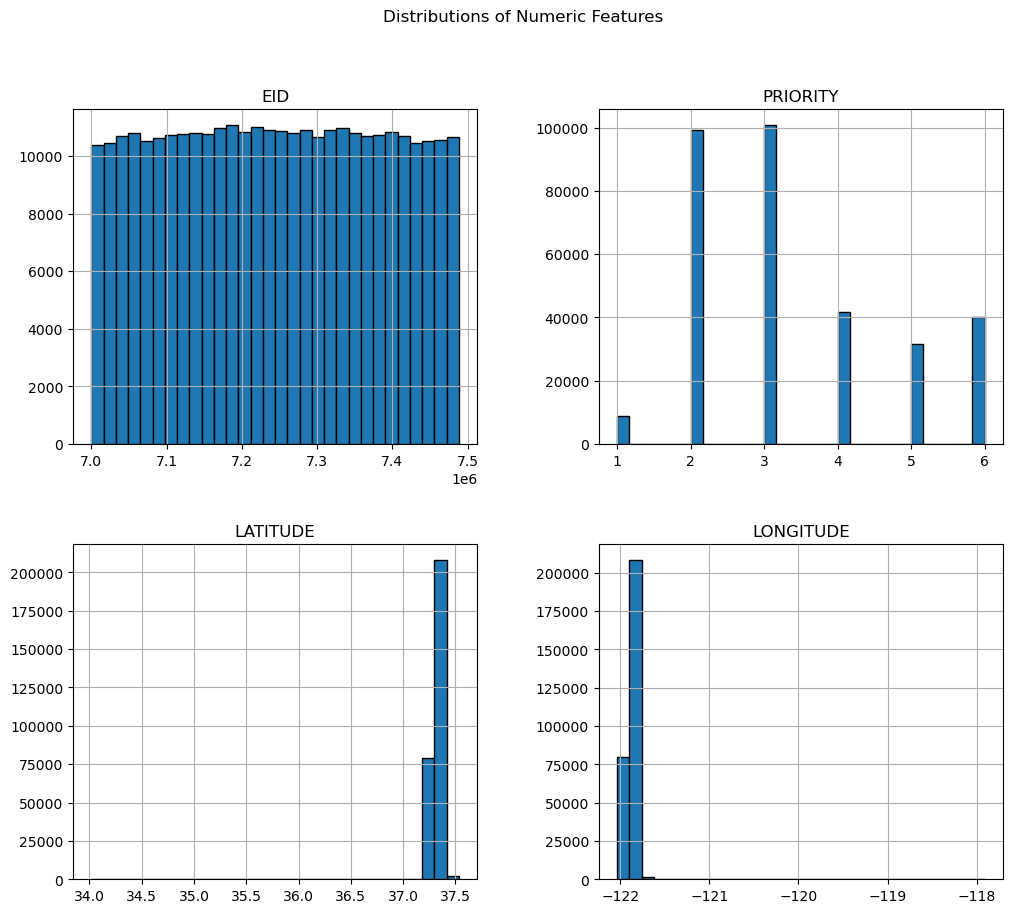

In [11]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [12]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9983
CITY                    0
STATE                   0
LATITUDE            33153
LONGITUDE           33153
neighborhood        34684
dtype: int64

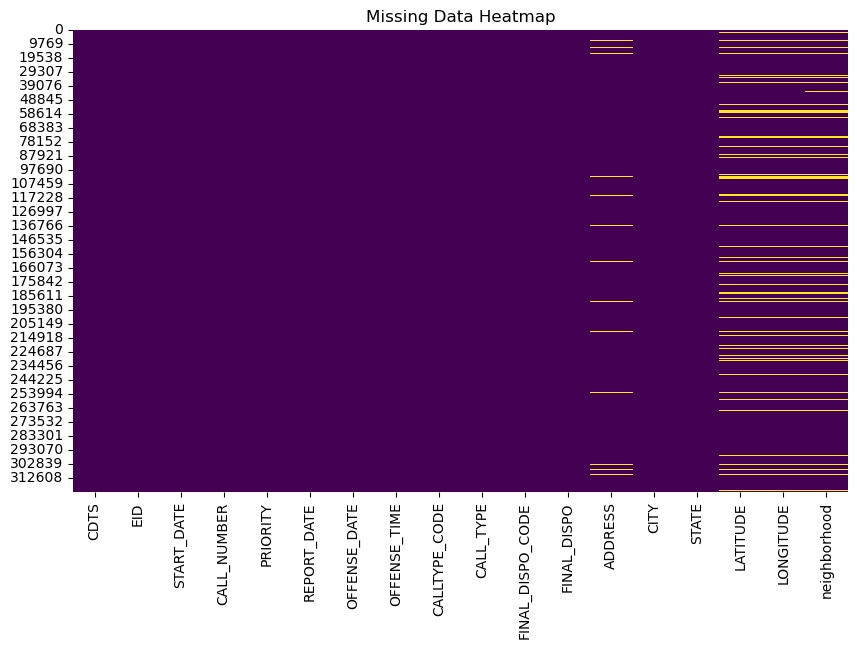

In [13]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [14]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320127 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316206 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81044 unique values
CALLTYPE_CODE: 213 unique values
CALL_TYPE: 206 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31667 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [15]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8599
Little Saigon and Spring Brook    5192
Trimble Business Area             4609
Five Wounds-San Jose High         4607
Steinbeck and Allen               4367
                                  ... 
San Jose Country Club               39
Alta Vista                          26
Linda Vista and Hillcrest           26
Meadowlands                         25
Santa Teresa Hills                  19
Name: count, Length: 295, dtype: int64

In [16]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          141153
CAN         42522
R           39976
G           21257
NR          13625
E           12319
D            8641
A            6429
DUPNCAN      5444
O            5245
H            4250
GD           4020
C            3854
B            3506
T            3217
U            2895
ADV          2783
F             980
M             105
Z              69
P              60
TOT            15
Name: count, dtype: int64

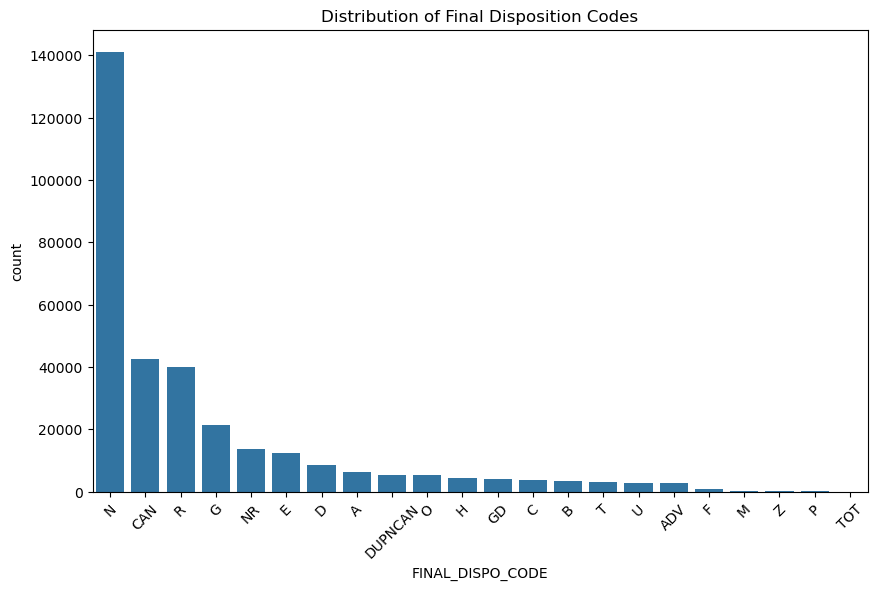

In [17]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [18]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    141153
Canceled                           42522
Report taken                       39976
Gone on Arrival/unable to loca     21257
No Response                        13625
No Disposition                     12331
Traffic Citation Issued, Non-H     12319
Traffic Citation Issued, Hazar      8641
Arrest Made                         6429
Supplemental report taken           5245
Courtesy Service/Citizen or ag      4250
Criminal Citation                   3854
Arrest by Warrant                   3506
Turned over To (TOT)                3217
Unfounded event                     2895
Field Interview (F.I.) Complet       980
Stranded motorist assist             105
Prior case, follow-up activity        60
Name: count, dtype: int64

In [20]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'CAN': 'Canceled',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to loca',
 'H': 'Courtesy Service/Citizen or ag',
 'GD': 'No Disposition',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'E': 'Traffic Citation Issued, Non-H',
 'ADV': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazar',
 'C': 'Criminal Citation',
 'F': 'Field Interview (F.I.) Complet',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'TOT': 'No Disposition'}

In [21]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '415': 'DISTURBANCE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '5150': 'MENTALLY DISTURBED PERSON',
 '23103': 'RECKLESS DRIVING',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '415F': 'DISTURBANCE, FAMILY',
 '10851': 'STOLEN VEHICLE',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1070': 'PROWLER',
 '415W': 'DISTURBANCE, WEAPON',
 '1066': 'SUSPICIOUS PERSON',
 'WELCK': 'WELFARE CHECK',
 '415A': 'DISTURBANCE, FIGHT',
 '911UNK': 'UNK TYPE 911 CALL',
 '1195': 'VEHICLE STOP',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415AEMS': 'DISTURBANCE, FIGHT (COMBINED E',
 '1125': 'TRAFFIC HAZARD',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '1091C': 'INJURED ANIMAL',
 '246': 'SHOOTING INTO OCCP VEH OR DWEL',
 '23152': 'MISDEMEANOR DUI',
 '1091A': 'VICIOUS ANIMAL',
 '6F': 'FELONY WANT',
 '484

## Focus on Target Dispositions

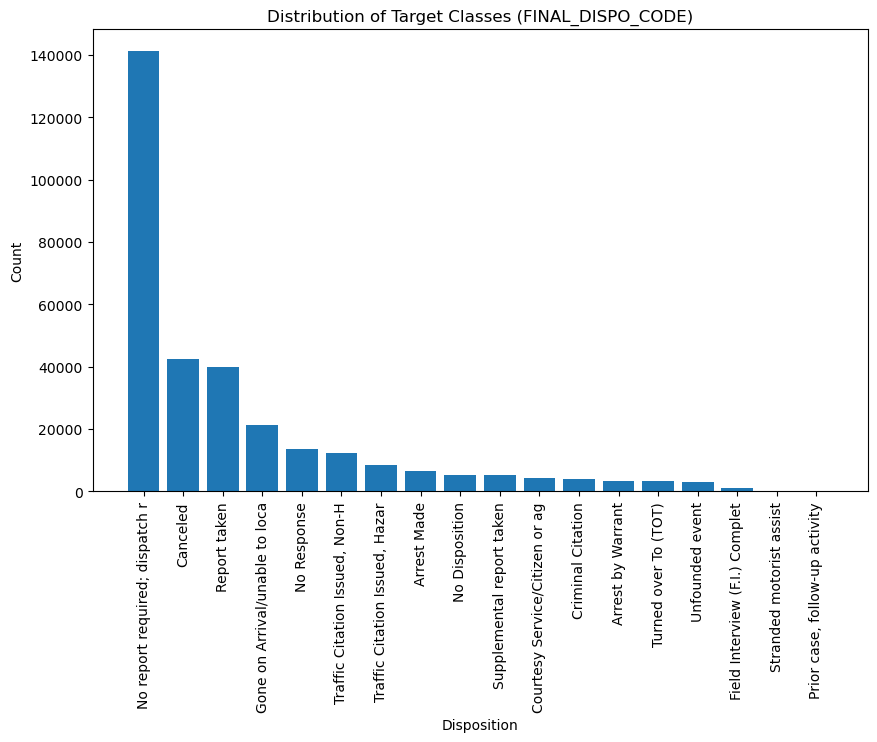

In [25]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [28]:
model_utils.transform_offense_date(all_police_df)

In [29]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    308576
A          6429
C          3854
B          3506
Name: count, dtype: int64

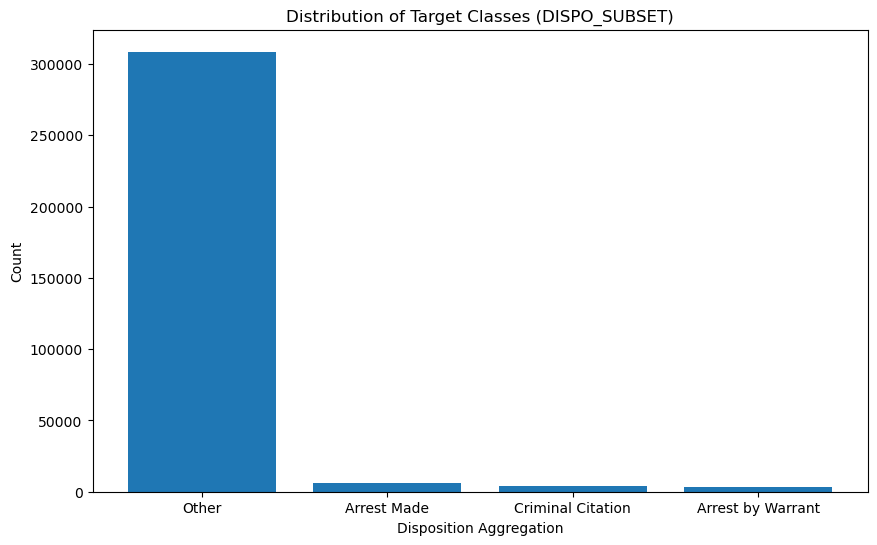

In [30]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [33]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 322365 rows before cleaning, 287681 rows after cleaning.


In [36]:
police_calls_encoded.shape

(287681, 15)

In [37]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,2,FDAID,0.958831,0.685861,Gramercy and Alexander,0,0,1,2018,No,Other,0.053515,0.919357,0.657625,0.470405
1,3,1033A,-1.286077,0.494535,Gunderson and Vista Park,0,0,1,2018,No,Other,0.082841,1.653993,-0.636010,0.244565
2,4,415M,-0.524901,-1.701696,Cadillac Winchester,0,0,1,2018,No,Other,0.076226,0.275521,0.893221,2.895769
3,4,415FC,-1.513652,-0.360214,Hammer,0,0,1,2018,No,Other,0.082686,2.291142,0.545238,0.129754
4,4,415M,0.596757,-0.390534,Horace Mann and SJSU,0,0,1,2018,No,Other,0.007985,0.356119,-0.233054,0.152517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322360,2,415,0.071586,-1.128270,Parkmoor,0,0,12,2018,No,Other,0.040363,0.005125,-0.080769,1.272992
322361,2,242,2.417488,-2.026405,Alviso,0,0,12,2018,No,A,0.117005,5.844249,-4.898811,4.106319
322362,2,WELCK,-0.334851,-0.605185,Downtown Lincoln Ave,0,0,12,2018,No,Other,0.034714,0.112125,0.202647,0.366249
322363,3,602PC,-1.777181,0.037938,Westfield Oakridge,0,0,12,2018,No,Other,0.095589,3.158373,-0.067424,0.001439


## Define X and Y

In [39]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [40]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(230144, 14)
(57537, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})
Counter({3: 9962, 0: 4670, 2: 2786, 1: 2506})


In [41]:
X_train.shape

(230144, 529)

In [42]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
27007,-0.249947,0.838534,-0.630857,-1.062002,-0.216725,-0.330832,-0.416307,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262704,0.465942,1.197790,-0.613984,-0.679610,0.322165,-0.520955,-0.430863,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14208,-1.681724,1.644869,-0.963209,0.037020,1.257988,-1.302781,-0.049216,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248000,-0.249947,-1.016108,0.350882,0.305491,0.021875,-0.169909,-0.607423,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27134,-0.965836,1.618581,-0.912549,-0.025802,1.194825,-1.203953,-0.115053,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37121,0.465942,0.073500,0.857969,-0.017344,-0.731534,0.216217,-0.183417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285730,-0.249947,0.485659,-0.754407,-1.140124,-0.561176,-0.181165,-0.297705,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47748,-0.965836,0.769816,0.521889,-0.461414,-0.298167,0.527074,-0.504227,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145979,1.897719,2.400444,-2.004307,1.667566,3.508041,-4.273718,2.090730,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})
y_test distribution: Counter({3: 55046, 0: 1168, 2: 697, 1: 626})
y_train_resampled distribution: Counter({3: 220182, 0: 4670, 2: 2786, 1: 2506})


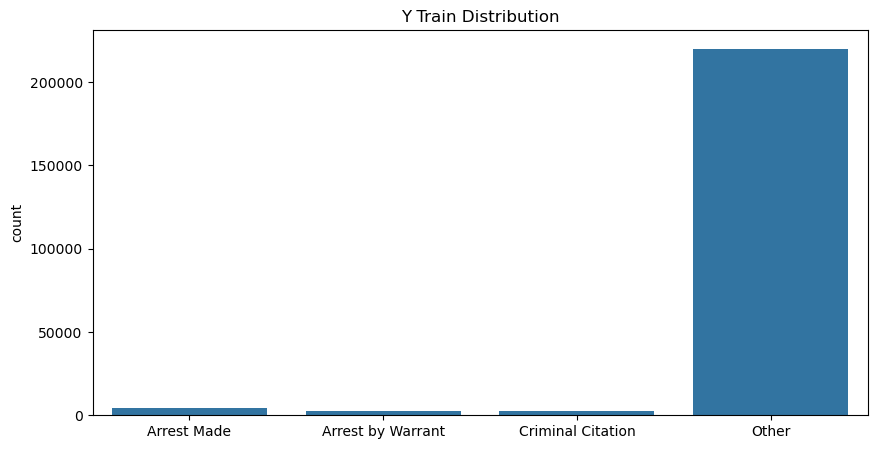

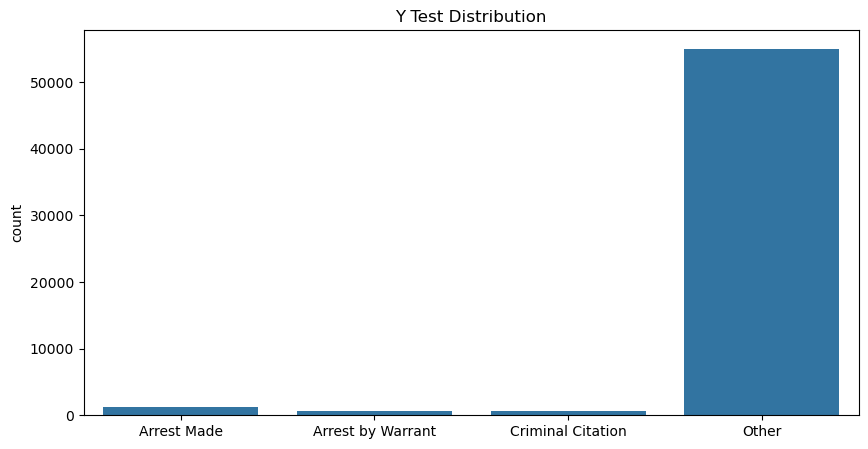

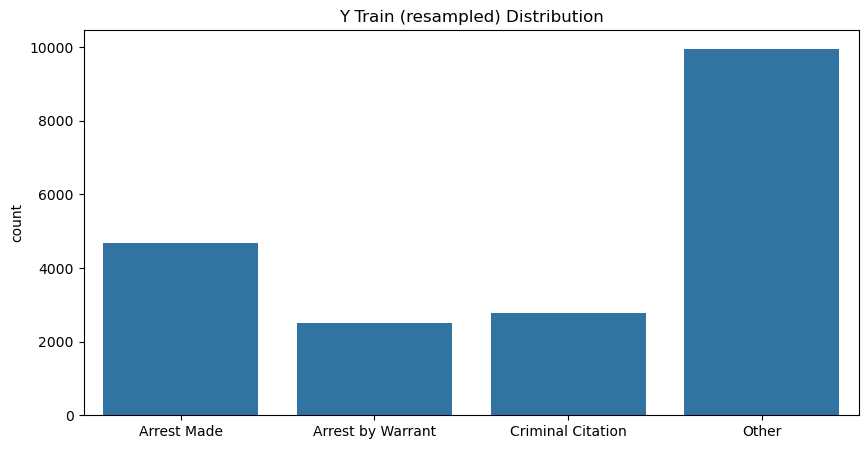

In [43]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [50]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [51]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [56]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1168
Arrest by Warrant       0.00      0.00      0.00       626
Criminal Citation       0.00      0.00      0.00       697
            Other       0.96      1.00      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.24      0.25      0.24     57537
     weighted avg       0.92      0.96      0.94     57537



### Logistic Regression

In [62]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [67]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [68]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.17      0.63      0.27      1168
Arrest by Warrant       0.33      0.60      0.42       626
Criminal Citation       0.16      0.44      0.24       697
            Other       0.99      0.90      0.94     55046

         accuracy                           0.89     57537
        macro avg       0.41      0.64      0.47     57537
     weighted avg       0.95      0.89      0.91     57537



#### Hyperparameter Tuning

In [70]:
grid_search_scoring_method = 'f1_macro'

In [74]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [75]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5692


In [77]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2018/best_logistic_regression.pkl']

In [81]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [82]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.31      0.41      1168
Arrest by Warrant       0.70      0.55      0.61       626
Criminal Citation       0.48      0.15      0.23       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.69      0.50      0.56     57537
     weighted avg       0.96      0.97      0.96     57537



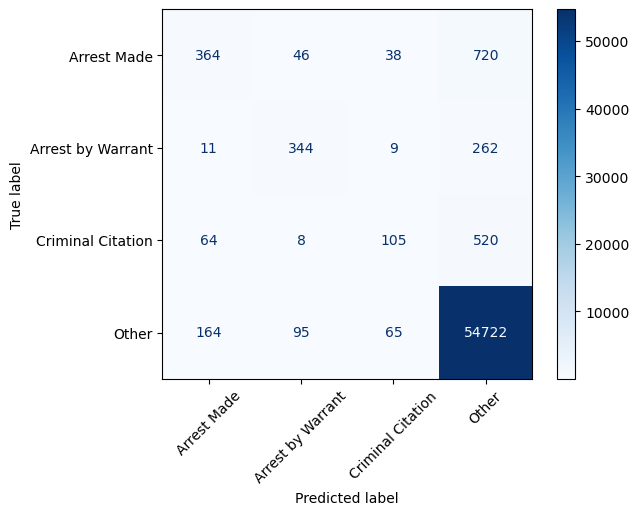

In [83]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [85]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [86]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [87]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.023319
5,DISTANCE_FROM_CENTER,0.001361
4,LONGITUDE,0.000753
1,neighborhood,0.000377
8,LONGITUDE^2,0.000290
9,AFTER_COVID_Yes,0.000000
2,PRIORITY,-0.000029
7,LATITUDE LONGITUDE,-0.000058
6,LATITUDE^2,-0.000116
3,LATITUDE,-0.000174


In [88]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [89]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                    Feature  Importance  \
200                        CALLTYPE_CODE_6M    0.006083   
184                      CALLTYPE_CODE_601T    0.003360   
199                        CALLTYPE_CODE_6F    0.002462   
3                      DISTANCE_FROM_CENTER    0.001361   
59                      CALLTYPE_CODE_11300    0.001159   
64                      CALLTYPE_CODE_11377    0.000898   
2                                 LONGITUDE    0.000753   
196                      CALLTYPE_CODE_647F    0.000724   
84                      CALLTYPE_CODE_14601    0.000666   
102                     CALLTYPE_CODE_22500    0.000579   
8                       CALLTYPE_CODE_1033A    0.000435   
75                       CALLTYPE_CODE_1195    0.000406   
218                    CALLTYPE_CODE_CODE6M    0.000377   
42                      CALLTYPE_CODE_10851    0.000348   
60                     CALLTYPE_CODE_11300G    0.000348   
82                      CALLTYPE_CODE_12025    0.000348 

In [90]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.766995
107                 Call Type: MISDEMEANOR DUI     3.092084
43     Call Type: STOLEN VEHICLE, GANG RELATED     2.775278
82      Call Type: CARRYING A CONCEALED WEAPON     2.700451
118      Call Type: BATTERY ON A PEACE OFFICER     2.576404
76           Call Type: VEHICLE STOP ON FEMALE    -2.570952
196                 Call Type: DRUNK IN PUBLIC     2.365976
108                      Call Type: FELONY DUI     2.341424
206               Call Type: UNK TYPE 911 CALL    -2.315391
117           Call Type: BATTERY ON AN OFFICER     2.275948
102               Call Type: PARKING VIOLATION    -2.274785
72   Call Type: VEHICLE ACCIDENT, PROPERTY DAM    -2.210082
225   Call Type: VIOLATION OF PROTECTIVE ORDER     2.207550
129    Call Type: REGISTRATION OF SEX OFFENDER     2.190858
171     Call Type: RECEIVE/POSSESS STOLEN PROP     2.038843
58                 

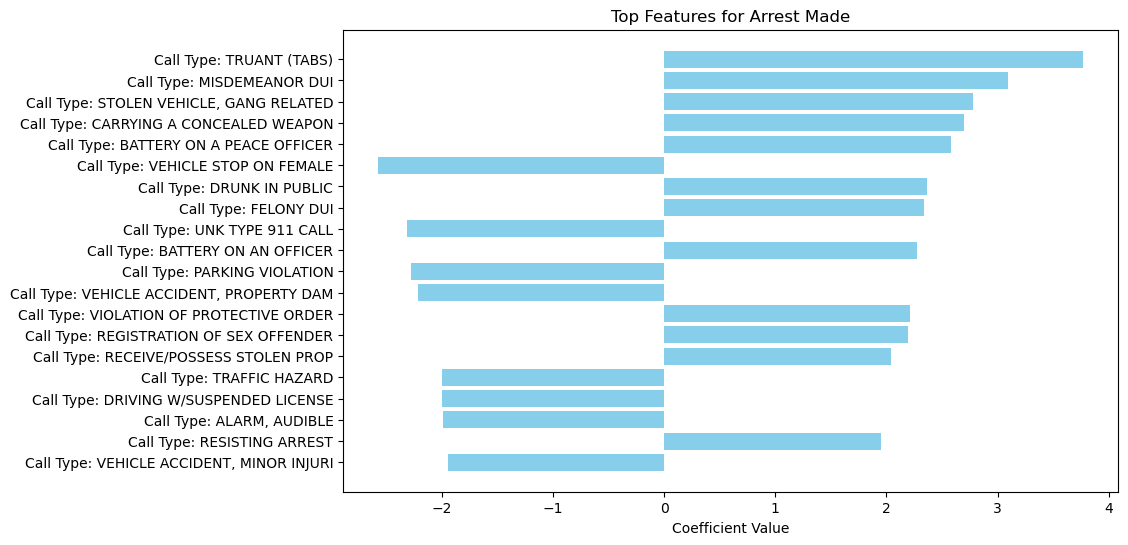

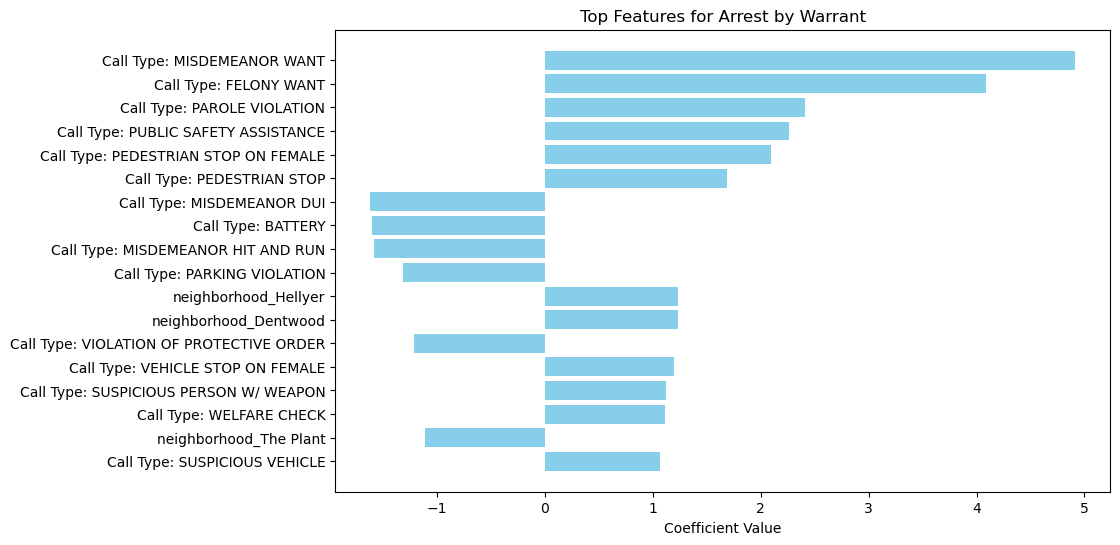

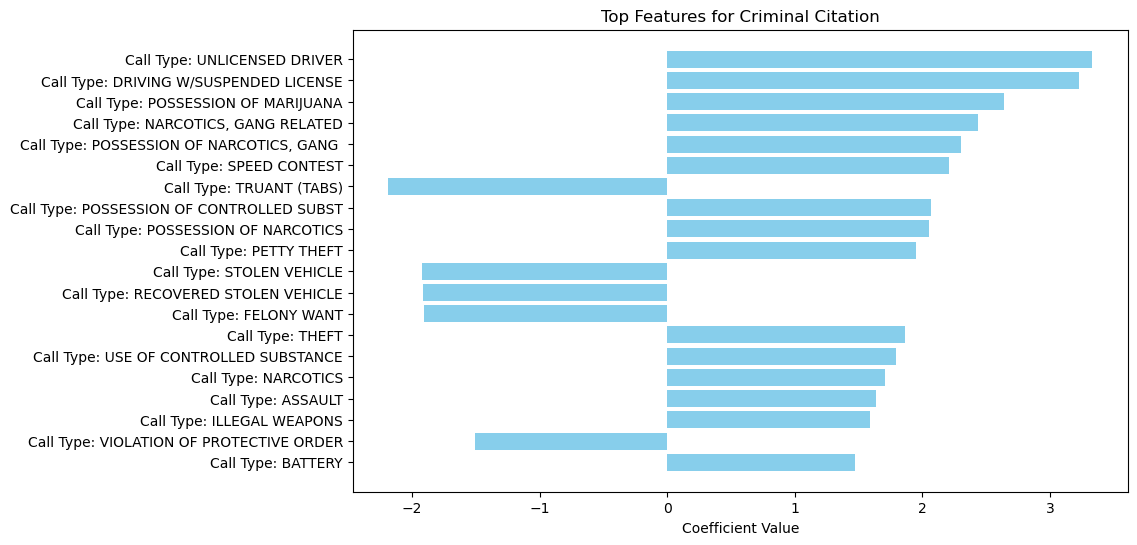

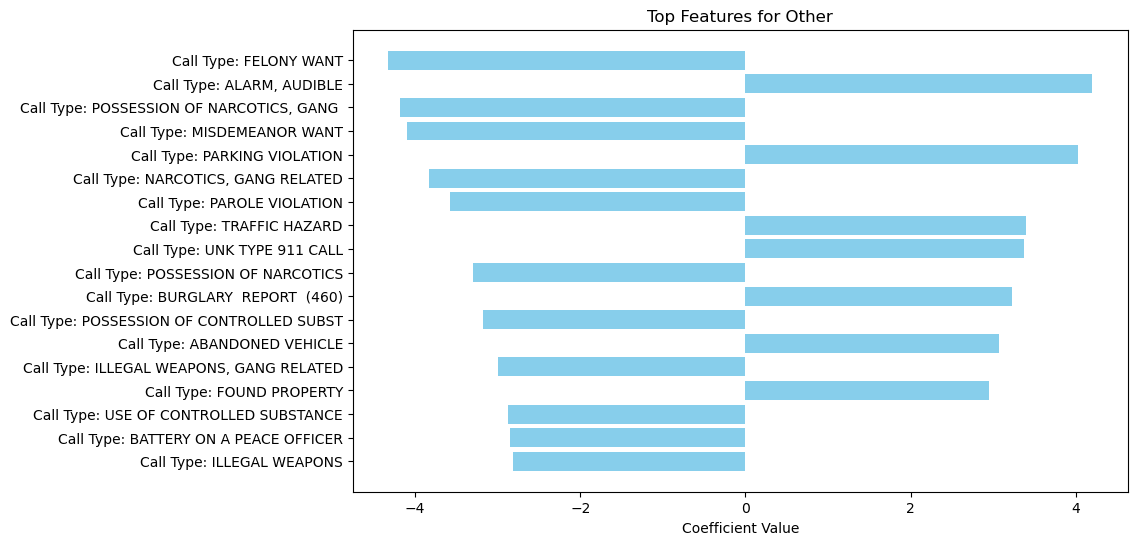

In [91]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [93]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [95]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.50      0.31      0.38      1168
Arrest by Warrant       0.64      0.47      0.54       626
Criminal Citation       0.34      0.16      0.22       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.61      0.48      0.53     57537
     weighted avg       0.95      0.96      0.96     57537



#### Hyperparameter Tuning and Cross Validation

In [100]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.55


In [101]:
best_rf = grid_rf.best_estimator_

In [102]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2018/best_random_forest.pkl']

In [103]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [104]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.50      0.31      0.38      1168
Arrest by Warrant       0.63      0.47      0.54       626
Criminal Citation       0.37      0.16      0.23       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.62      0.48      0.53     57537
     weighted avg       0.95      0.96      0.96     57537



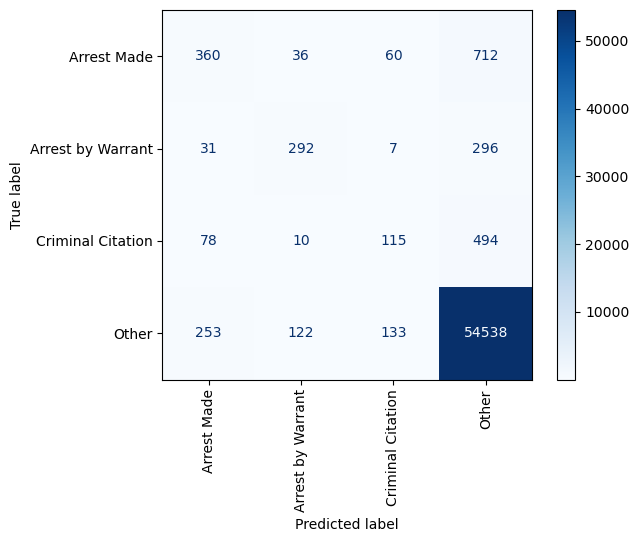

In [105]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [106]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 11:07:40,037] A new study created in memory with name: no-name-8b30702b-cb14-4f83-a462-1cbf37026290
[I 2024-10-08 11:07:41,486] Trial 0 finished with value: 0.6429126928657988 and parameters: {'n_estimators': 75, 'max_depth': 66, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6429126928657988.
[I 2024-10-08 11:07:42,604] Trial 1 finished with value: 0.6510696251301329 and parameters: {'n_estimators': 53, 'max_depth': 67, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6510696251301329.
[I 2024-10-08 11:07:43,678] Trial 2 finished with value: 0.5798521202128072 and parameters: {'n_estimators': 90, 'max_depth': 58, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.6510696251301329.
[I 2024-10-08 11:07:44,983] Trial 3 finished with value: 0.6606116610139058 and parameters: {'n_estimators': 62, 'max_depth': 90, 'mi

Best hyperparameters: {'n_estimators': 82, 'max_depth': 74, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [107]:
best_params = study.best_params
best_params

{'n_estimators': 82,
 'max_depth': 74,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 'sqrt'}

In [108]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=74, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=82, n_jobs=-1)

In [109]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.68      0.27      0.38      1168
Arrest by Warrant       0.70      0.55      0.62       626
Criminal Citation       0.47      0.16      0.24       697
            Other       0.97      1.00      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.71      0.49      0.56     57537
     weighted avg       0.96      0.97      0.96     57537



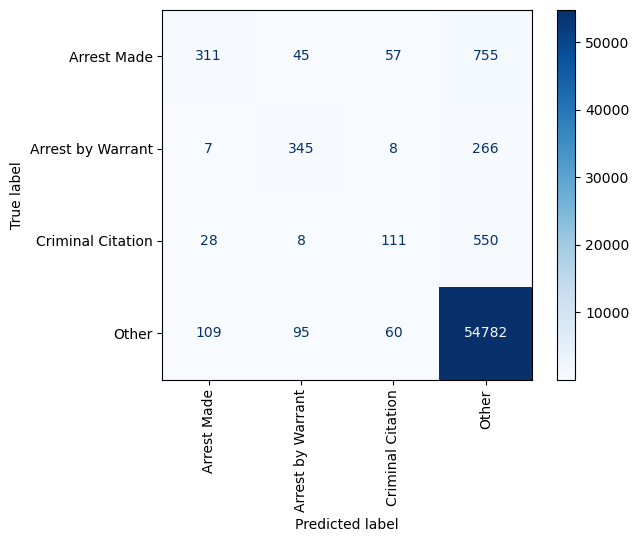

In [110]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

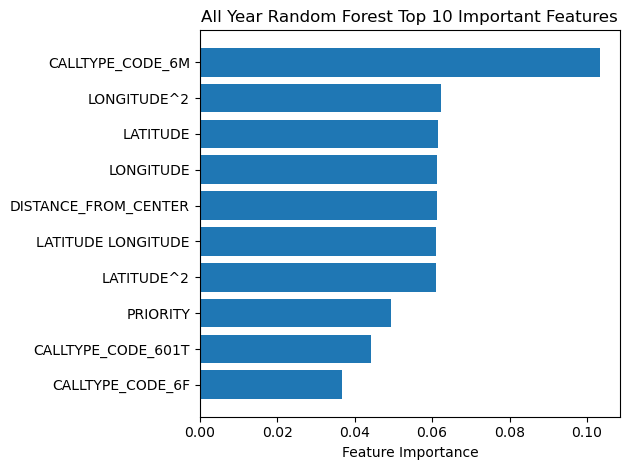

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [114]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [115]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9562 - loss: 0.1933 - val_accuracy: 0.9670 - val_loss: 0.1295
Epoch 2/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9659 - loss: 0.1323 - val_accuracy: 0.9662 - val_loss: 0.1277
Epoch 3/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9657 - loss: 0.1303 - val_accuracy: 0.9669 - val_loss: 0.1256
Epoch 4/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9661 - loss: 0.1251 - val_accuracy: 0.9660 - val_loss: 0.1263
Epoch 5/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9668 - loss: 0.1227 - val_accuracy: 0.9655 - val_loss: 0.1286
Epoch 6/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9678 - loss: 0.1178 - val_accuracy: 0.9662 - val_loss: 0.1302


In [117]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2018/mlp_model.pkl']

In [118]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [119]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.9648 - loss: 0.1336
Test Accuracy: 0.9651


In [120]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.33      0.43      1168
Arrest by Warrant       0.70      0.55      0.61       626
Criminal Citation       0.46      0.22      0.29       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.69      0.52      0.58     57537
     weighted avg       0.96      0.97      0.96     57537



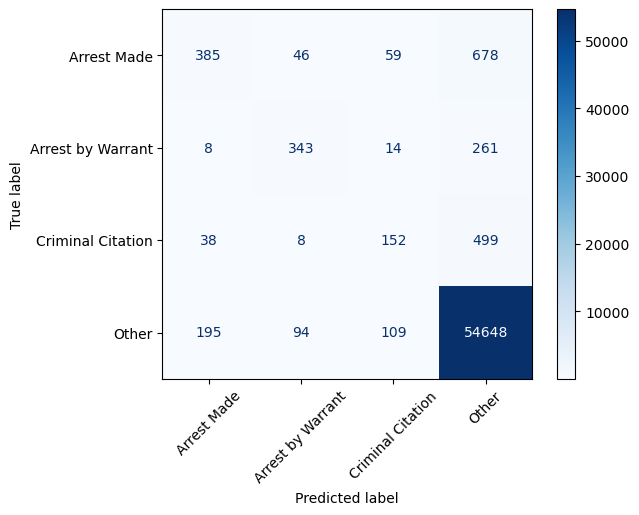

In [121]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [124]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 11:09:06,466] A new study created in memory with name: no-name-9b3d25b5-492a-4fd2-8079-4340240c1ae4
[I 2024-10-08 11:09:18,404] Trial 0 finished with value: 0.5515494538077745 and parameters: {'learning_rate': 0.001198546223407526, 'max_depth': 3, 'subsample': 0.6910307798837257, 'colsample_bytree': 0.759919449376611, 'gamma': 1.4720469932845541e-05, 'reg_alpha': 9.079661781314666e-07, 'reg_lambda': 3.716017512711851e-05}. Best is trial 0 with value: 0.5515494538077745.
[I 2024-10-08 11:09:40,608] Trial 1 finished with value: 0.6411113427184463 and parameters: {'learning_rate': 0.010290792413527877, 'max_depth': 9, 'subsample': 0.9835925923725847, 'colsample_bytree': 0.7711207141676433, 'gamma': 7.626731841858594e-07, 'reg_alpha': 2.8209058083652444e-07, 'reg_lambda': 3.082504365020906e-08}. Best is trial 1 with value: 0.6411113427184463.
[I 2024-10-08 11:09:56,720] Trial 2 finished with value: 0.5948531441884133 and parameters: {'learning_rate': 0.0014638500819746882, 'm

Actual runtime: 391.15 seconds (6.52 minutes)
Best parameters found:  {'learning_rate': 0.09924065433887633, 'max_depth': 5, 'subsample': 0.7599148475650767, 'colsample_bytree': 0.6885473093817236, 'gamma': 0.8110032620629681, 'reg_alpha': 0.0027420795326279905, 'reg_lambda': 3.75222846050498e-05}
Best F1 macro score:  0.6828365210010501


In [125]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6885473093817236, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.8110032620629681, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09924065433887633,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.75      0.15      0.26      1168
Arrest by Warrant       0.69      0.53      0.60       626
Criminal Citation       0.47      0.14      0.22       697
            Other       0.97      1.00      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.72      0.46      0.51     57537
     weighted avg       0.96      0.96      0.95     57537



In [127]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2018/xgb_model.pkl']

In [128]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [130]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [131]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5598126585837698
RF F1: 0.5319710604492576
XGB F1: 0.5143645752560156


In [132]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [133]:
best_rf

RandomForestClassifier(n_estimators=60)

In [134]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6885473093817236, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.8110032620629681, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09924065433887633,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [136]:
X_train_float = X_train.astype('float64')

In [137]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6885473093817236,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [138]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2018/stacking_2.pkl']

In [139]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [140]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5835603465948066


In [141]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.36      0.45      1168
Arrest by Warrant       0.70      0.55      0.61       626
Criminal Citation       0.46      0.21      0.29       697
            Other       0.98      0.99      0.98     55046

         accuracy                           0.97     57537
        macro avg       0.68      0.53      0.58     57537
     weighted avg       0.96      0.97      0.96     57537



## Results

In [143]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.956706,0.250000,0.239177,0.244469
Logistic Regression,0.965205,0.501481,0.689643,0.559813
Random Forest,0.961208,0.482609,0.617919,0.531971
MLP,0.965083,0.522098,0.685760,0.580423
XGB,0.963849,0.455281,0.722297,0.514365
Ensemble,0.965587,0.527204,0.683580,0.583560


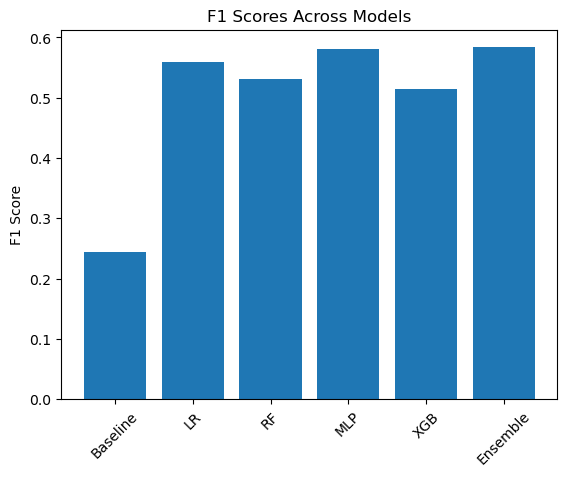

In [144]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [146]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [147]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

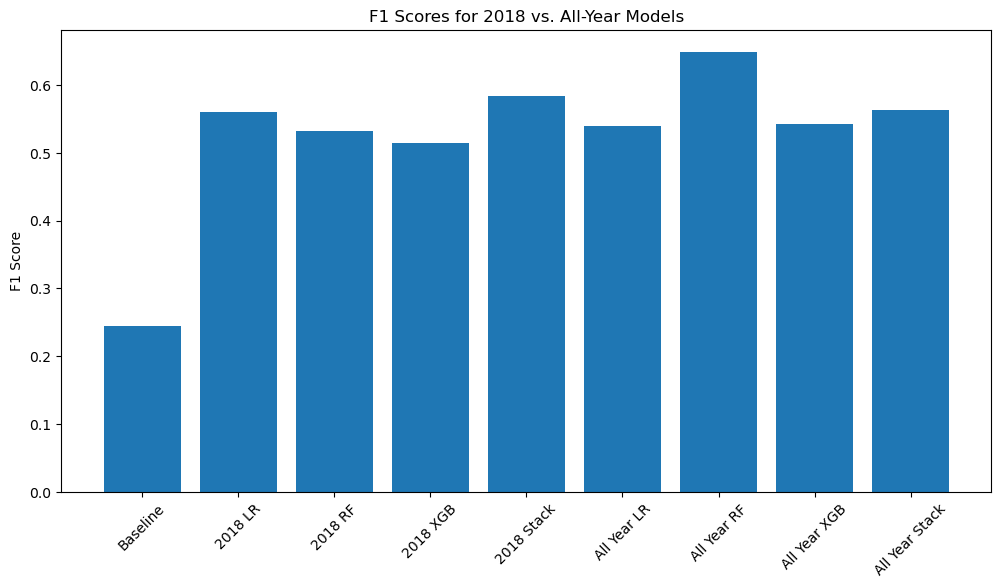

In [148]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2018 vs. Non-2018 Models

In [150]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2017, 2019, 2020, 2021, 2022, 2023, 2024]

In [151]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(322365, 24)

In [152]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3264492 rows before cleaning, 2912755 rows after cleaning.


(2912755, 15)

In [153]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2330204, 14)
(582551, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2236617, 0: 47925, 2: 25895, 1: 19767})
Counter({3: 93587, 0: 47925, 2: 25895, 1: 19767})


In [154]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [155]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2018 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.37      0.44     11981
Arrest by Warrant       0.69      0.55      0.61      4942
Criminal Citation       0.46      0.24      0.31      6474
            Other       0.98      0.99      0.98    559154

         accuracy                           0.97    582551
        macro avg       0.67      0.54      0.59    582551
     weighted avg       0.96      0.97      0.96    582551



In [156]:
y_pred_rf_oy_2018 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2018, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2018 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.33      0.42      1168
Arrest by Warrant       0.69      0.51      0.59       626
Criminal Citation       0.46      0.14      0.22       697
            Other       0.97      0.99      0.98     55046

         accuracy                           0.96     57537
        macro avg       0.67      0.50      0.55     57537
     weighted avg       0.96      0.96      0.96     57537



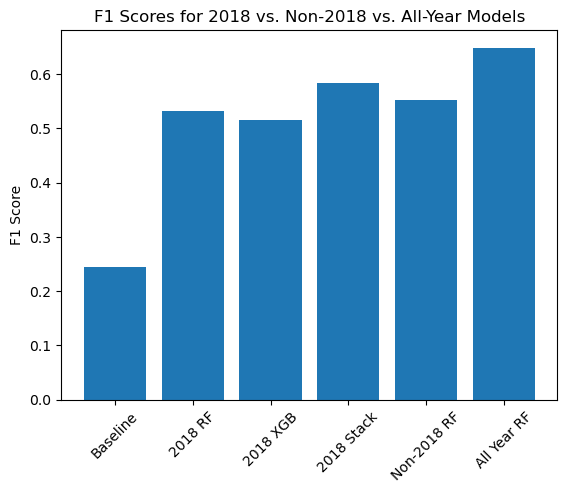

In [157]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2018, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()